# Train Variational Quantum Circuits by using evovaq and Qiskit

## 1) Training a Variational Quantum Classifier through an evolutionary algorithm

#### Importing modules

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit import Aer, execute
from evovaq.problem import Problem
from evovaq.GeneticAlgorithm import GA
import evovaq.tools.operators as op
import numpy as np

#### Uploading the classical data

In [2]:
iris = load_iris()

# for the sake of simplicity, we consider only two classes and two features
iris_data = iris.data[:100, :2]
iris_target = iris.target[:100]   # 0 o 1

# split into train and test subsets
train_data, test_data, train_labels, test_labels = train_test_split(iris_data, iris_target, test_size=0.2,
                                                                    random_state=42)

# the training labels are in {0, 1} but we'll use {-1, 1} as class labels
train_labels = 2 * train_labels - 1
test_labels = 2 * test_labels - 1

# pre-processing
scaler = StandardScaler()
scaler.fit(train_data)

train_data_std = scaler.transform(train_data)
test_data_std = scaler.transform(test_data)

#### Building the Variational Quantum Classifier

In [3]:
# encoding classical data in a quantum system through a FeatureMap
dim = 2
feature_map = ZZFeatureMap(dim, reps=1)  # let's keep it simple

# defining an ansatz to train
ansatz = RealAmplitudes(num_qubits=dim, entanglement='linear', reps=1)  # also simple here!

# putting together our circuit
circuit = feature_map.compose(ansatz)

# measuring all the qubits to retrieve label information
circuit.measure_all()

In [4]:
def get_label_prediction(circuit, features, params):
    bound_circuit = circuit.bind_parameters(np.concatenate((features,params)))
    backend = Aer.get_backend('qasm_simulator')
    counts = execute(bound_circuit, backend).result().get_counts()
    parity_plus = 0
    for state, count in counts.items():
        if state == '00' or state == '11':
            parity_plus += count
    return parity_plus/sum(counts.values())

#### Defining the cost function to be minimized

In [5]:
def cost_function(params):
    predictions = [get_label_prediction(circuit, features, params) for features in train_data_std]
    return log_loss(train_labels, predictions)

#### Setting up the problem

In [6]:
problem = Problem(ansatz.num_parameters, (0, np.pi), cost_function)

#### Selecting an evolutionary algirthm to train the VQC

In [7]:
optimizer = GA(selection=op.sel_tournament, crossover=op.cx_two_point, mutation=op.mut_gaussian)

res = optimizer.optimize(problem, 10, max_gen=10, seed=42)
res

Generations:   0%|                                      | 0/10 [00:00<?, ?gen/s]

********** Execution #1 **********
gen    nfev    min     max       mean      std
-----  ------  ------  --------  --------  ---------
0      10      0.6808  0.879397  0.765461  0.0593827


Generations:  10%|███                           | 1/10 [00:02<00:18,  2.08s/gen]


1      7       0.676872  0.758481  0.713315  0.0340471


Generations:  20%|██████                        | 2/10 [00:04<00:16,  2.00s/gen]


2      7       0.676872  0.766437  0.689363  0.0258898


Generations:  30%|█████████                     | 3/10 [00:06<00:14,  2.05s/gen]


3      7       0.674559  0.702455  0.68352  0.00975851


Generations:  40%|████████████                  | 4/10 [00:08<00:12,  2.01s/gen]


4      7       0.674559  0.684412  0.677637  0.00286984


Generations:  50%|███████████████               | 5/10 [00:10<00:10,  2.04s/gen]


5      7       0.670847  0.675037  0.673525  0.00134072


Generations:  60%|██████████████████            | 6/10 [00:12<00:08,  2.03s/gen]


6      7       0.66893  0.693982  0.675587  0.006995


Generations:  70%|█████████████████████         | 7/10 [00:14<00:05,  1.96s/gen]


7      6       0.663053  0.677272  0.670709  0.00412192


Generations:  80%|████████████████████████      | 8/10 [00:16<00:04,  2.01s/gen]


8      8       0.663053  0.690409  0.674068  0.00978091


Generations:  90%|███████████████████████████   | 9/10 [00:17<00:01,  1.89s/gen]


9      6       0.663053  0.705428  0.673294  0.013776


Generations: 100%|█████████████████████████████| 10/10 [00:19<00:00,  1.88s/gen]


10     7       0.663053  0.676484  0.669449  0.00554707


  fun: 0.663053127338853
  gen: 10
  log: {'gen': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'nfev': [10, 7, 7, 7, 7, 7, 7, 6, 8, 6, 7], 'min': [0.6807999188531141, 0.6768724444126989, 0.6768724444126989, 0.6745587706684608, 0.6745587706684608, 0.6708470019176993, 0.6689302472881989, 0.663053127338853, 0.663053127338853, 0.663053127338853, 0.663053127338853], 'max': [0.8793966838196766, 0.7584809350029351, 0.7664371747897792, 0.7024545375266389, 0.6844123634722431, 0.6750373592494312, 0.6939821483781708, 0.6772717721886362, 0.6904090957387958, 0.7054282049512107, 0.6764838382881703], 'mean': [0.7654611838818954, 0.7133153116551064, 0.6893628359050593, 0.683519674252582, 0.6776372636720364, 0.6735246860302981, 0.6755865066187884, 0.6707092390684137, 0.6740675462234635, 0.6732937305691704, 0.6694486654282978], 'std': [0.05938273235746133, 0.0340471156969182, 0.025889798091479413, 0.009758513046126351, 0.002869839450965264, 0.001340719324984954, 0.006994999007703682, 0.004121915552783661, 0.0097

#### Testing the optimal solution found

In [8]:
test_predictions = [1 if get_label_prediction(circuit, features, res.x) > 0.5 else -1 for features in test_data_std]
test_accuracy = accuracy_score(test_labels, test_predictions)
print("Accuracy on the test subset:", test_accuracy)

Accuracy on the test subset: 0.5


## 2) QAOA trained by an evolutionary algorithm to solve MaxCut problem

#### Importing modules

In [9]:
import networkx as nx
import numpy as np
from qiskit import execute, Aer
from qiskit.visualization import plot_histogram
from qiskit_optimization.applications import Maxcut
from qiskit.circuit.library import QAOAAnsatz
from evovaq.problem import Problem
import evovaq.tools.operators as op
from evovaq.tools.distances import euclidean_distance
from evovaq.CHCAlgorithm import CHC

#### Defining the graph

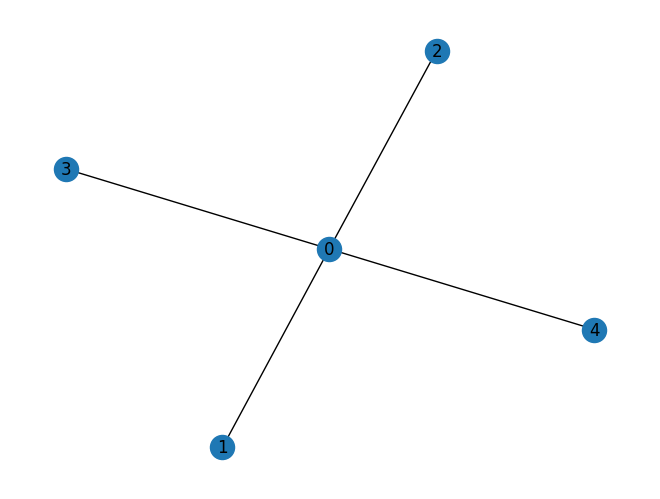

In [10]:
num_nodes = 5
edges = [(0, 1), (0, 2), (0, 3), (0, 4)]

G = nx.Graph()
G.add_nodes_from(range(num_nodes))
G.add_edges_from(edges)
nx.draw(G, with_labels=True)

#### Mapping the MaxCut problem in a QAOA circuit ansatz

##### 1 - Trasforming the MaxCut instance in a quadratic problem

In [11]:
maxcut_prob = Maxcut(G)
maxcut_qp = maxcut_prob.to_quadratic_program()
print(maxcut_qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_0*x_3 - 2*x_0*x_4 + 4*x_0 + x_1 + x_2 + x_3 + x_4

Subject to
  No constraints

  Binary variables (5)
    x_0 x_1 x_2 x_3 x_4



##### 2 - Defining the Hamiltonian by mapping the QUBO problem in an Ising Model

In [12]:
# Maxcut problem to Hamiltonian operator
hamiltonian, offset = maxcut_qp.to_ising()

##### 3 - Building the QAOA circuit based on the MaxCut instance

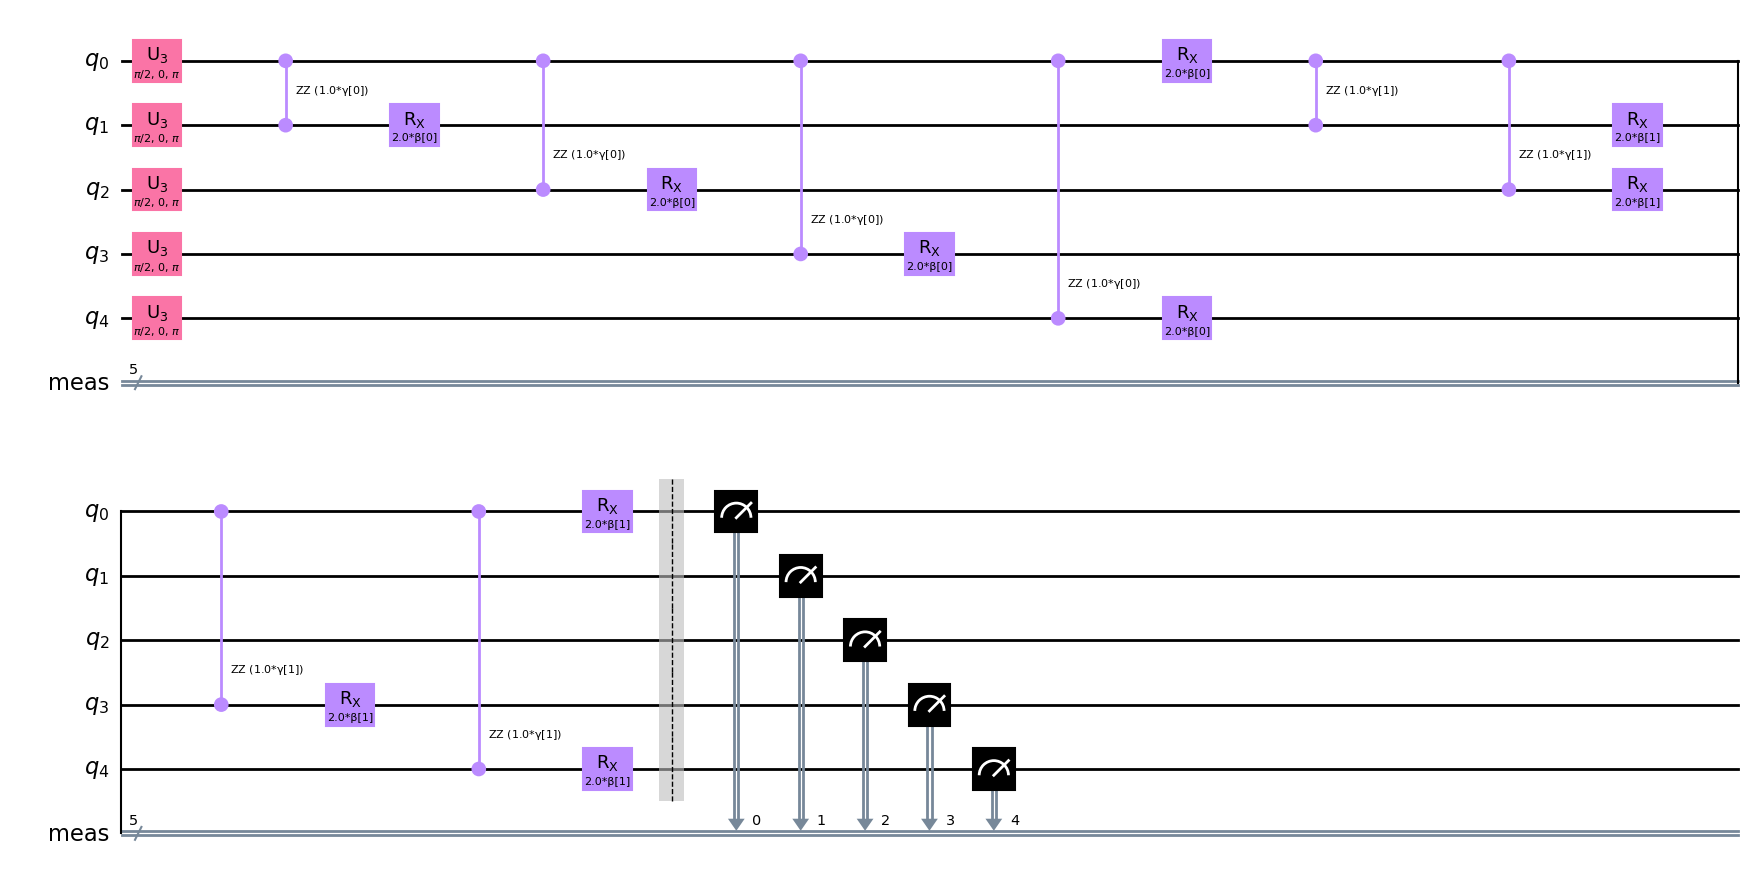

In [13]:
# QAOA ansatz circuit
qaoa_circuit = QAOAAnsatz(hamiltonian, reps=2)
qaoa_circuit.measure_all()
qaoa_circuit.decompose(reps=3).draw('mpl')

#### Defining the cost function to be minimized

In [14]:
def cost_function(params):
    backend = Aer.get_backend('qasm_simulator')
    # Execute the QAOA circuit to get the counts
    bound_qaoa_circuit = qaoa_circuit.bind_parameters(params)
    counts = execute(bound_qaoa_circuit, backend, shots=512).result().get_counts()
    cost_value = 0
    # Compute the cost value by using the maxcut objective function
    for bitstring, count in counts.items():
        cost_value -= count * maxcut_qp.objective.evaluate([int(bit) for bit in bitstring[::-1]])
    return cost_value / sum(counts.values())


#### Setting up the problem

In [15]:
qaoa_problem = Problem(qaoa_circuit.num_parameters, (0, np.pi), cost_function)

#### Selecting an evolutionary algirthm to train the QAOA circuit

In [16]:
optimizer = CHC(crossover=op.cx_blx_alpha, distance=euclidean_distance)

res = optimizer.optimize(qaoa_problem, 10, max_gen=10, seed=42)
res


Generations:  40%|████████████                  | 4/10 [00:00<00:00, 14.62gen/s]


********** Execution #1 **********
gen    nfev    min       max        mean      std
-----  ------  --------  ---------  --------  --------
0      10      -3.17188  -0.667969  -1.83594  0.680941

1      8       -3.17188  -1.90234  -2.28223  0.362334

2      8       -3.17188  -1.90234  -2.28223  0.362334

3      4       -3.17188  -2.0332  -2.40371  0.38506

4      4       -3.17188  -2.125  -2.55781  0.319099

5      2       -3.17188  -2.3418  -2.63086  0.254757

6      2       -3.17188  -2.43164  -2.68145  0.242253

7      2       -3.17188  -2.43164  -2.68145  0.242253

8      2       -3.17188  -2.43359  -2.71094  0.227552


Generations: 100%|█████████████████████████████| 10/10 [00:00<00:00, 17.11gen/s]


9      4       -3.23242  -2.56836  -2.83262  0.226028

10     6       -3.23242  -2.62109  -2.9082  0.191944


  fun: -3.232421875
  gen: 10
  log: {'gen': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'nfev': [10, 8, 8, 4, 4, 2, 2, 2, 2, 4, 6], 'min': [-3.171875, -3.171875, -3.171875, -3.171875, -3.171875, -3.171875, -3.171875, -3.171875, -3.171875, -3.232421875, -3.232421875], 'max': [-0.66796875, -1.90234375, -1.90234375, -2.033203125, -2.125, -2.341796875, -2.431640625, -2.431640625, -2.43359375, -2.568359375, -2.62109375], 'mean': [-1.8359375, -2.2822265625, -2.2822265625, -2.4037109375, -2.5578125, -2.630859375, -2.6814453125, -2.6814453125, -2.7109375, -2.8326171875, -2.908203125], 'std': [0.6809412825445653, 0.36233416743271696, 0.36233416743271696, 0.3850600178494145, 0.3190992648382514, 0.2547566887423849, 0.24225277913077084, 0.24225277913077084, 0.22755205502069328, 0.2260282122801975, 0.19194360159017088]}
 nfev: 42
    x: array([0.95594067, 0.40862134, 2.07437329, 1.4012871 ])

#### Testing the optimal angles found

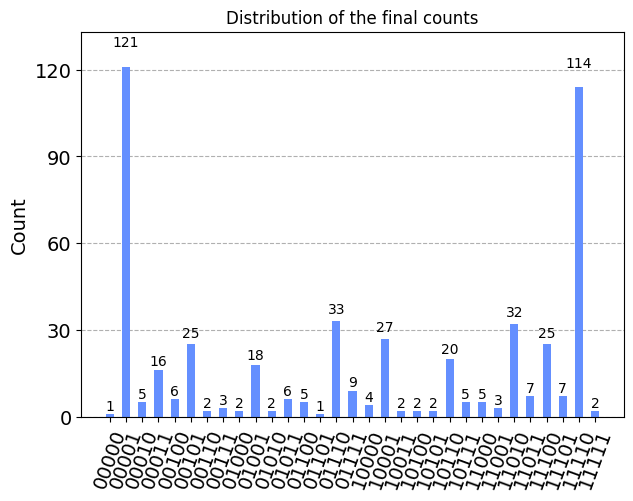

In [17]:
backend = Aer.get_backend('qasm_simulator')
trained_qaoa_circuit = qaoa_circuit.bind_parameters(res.x)
counts = execute(trained_qaoa_circuit, backend, shots=512).result().get_counts()
plot_histogram(counts, title='Distribution of the final counts')

In [18]:
bitstring = maxcut_prob.sample_most_likely(counts)
print('Optimal solution: ', bitstring)

Optimal solution:  [1 0 0 0 0]


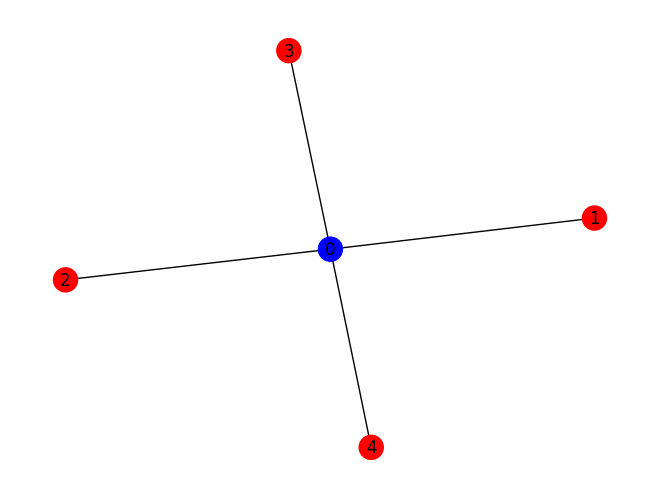

In [19]:
maxcut_prob.draw(bitstring)

## 3) VQE trained by an evolutionary algorithm to solve Traveling Salesman Problem 

#### Importing modules

In [41]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from qiskit_optimization.applications import Tsp
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.circuit.library import TwoLocal
from qiskit_aer.primitives import Estimator
from qiskit.primitives import Sampler
from qiskit_algorithms import NumPyMinimumEigensolver
from evovaq.problem import Problem
from evovaq.BigBangBigCrunch import BBBC

#### Defining the TSP instance

In [42]:
num_cities = 3
tsp = Tsp.create_random_instance(num_cities, seed=123)
adj_matrix = nx.to_numpy_array(tsp.graph)
print("Distances between cities \n", adj_matrix)

Distances between cities 
 [[ 0. 48. 91.]
 [48.  0. 63.]
 [91. 63.  0.]]


{(0, 1): Text(45.135586801037746, 11.90964147504462, '48.0'),
 (0, 2): Text(42.91288821665869, 43.295776272899815, '91.0'),
 (1, 2): Text(19.81328869288209, 49.823315867722165, '63.0')}

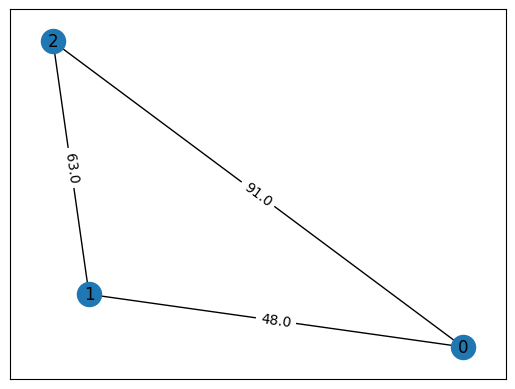

In [43]:
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
nx.draw_networkx(tsp.graph, pos=pos)
edge_labels = nx.get_edge_attributes(tsp.graph, "weight")
nx.draw_networkx_edge_labels(tsp.graph, pos=pos, edge_labels=edge_labels)

#### Mapping the TSP instance in an hamiltonian suitable for VQE

##### 1 - Trasforming the TSP instance in a quadratic problem

In [44]:
tsp_qp = tsp.to_quadratic_program()
print(tsp_qp.prettyprint())

Problem name: TSP

Minimize
  48*x_0_0*x_1_1 + 48*x_0_0*x_1_2 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_2
  + 48*x_0_1*x_1_0 + 48*x_0_1*x_1_2 + 91*x_0_1*x_2_0 + 91*x_0_1*x_2_2
  + 48*x_0_2*x_1_0 + 48*x_0_2*x_1_1 + 91*x_0_2*x_2_0 + 91*x_0_2*x_2_1
  + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_2 + 63*x_1_1*x_2_0 + 63*x_1_1*x_2_2
  + 63*x_1_2*x_2_0 + 63*x_1_2*x_2_1

Subject to
  Linear constraints (6)
    x_0_0 + x_0_1 + x_0_2 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 == 1  'c1'
    x_2_0 + x_2_1 + x_2_2 == 1  'c2'
    x_0_0 + x_1_0 + x_2_0 == 1  'c3'
    x_0_1 + x_1_1 + x_2_1 == 1  'c4'
    x_0_2 + x_1_2 + x_2_2 == 1  'c5'

  Binary variables (9)
    x_0_0 x_0_1 x_0_2 x_1_0 x_1_1 x_1_2 x_2_0 x_2_1 x_2_2



##### 2 - Defining the Hamiltonian by mapping the QUBO problem in an Ising Model

In [45]:
qp2qubo = QuadraticProgramToQubo()
tsp_qubo = qp2qubo.convert(tsp_qp)
hamiltonian, offset = tsp_qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(hamiltonian))

Offset: 7581.0
Ising Hamiltonian:
-1282.5 * IIIIIIIIZ
- 1282.5 * IIIIIIIZI
- 1282.5 * IIIIIIZII
- 1268.5 * IIIIIZIII
- 1268.5 * IIIIZIIII
- 1268.5 * IIIZIIIII
- 1290.0 * IIZIIIIII
- 1290.0 * IZIIIIIII
- 1290.0 * ZIIIIIIII
+ 606.5 * IIIIIIIZZ
+ 606.5 * IIIIIIZIZ
+ 606.5 * IIIIIZIIZ
+ 12.0 * IIIIZIIIZ
+ 12.0 * IIIZIIIIZ
+ 606.5 * IIZIIIIIZ
+ 22.75 * IZIIIIIIZ
+ 22.75 * ZIIIIIIIZ
+ 606.5 * IIIIIIZZI
+ 12.0 * IIIIIZIZI
+ 606.5 * IIIIZIIZI
+ 12.0 * IIIZIIIZI
+ 22.75 * IIZIIIIZI
+ 606.5 * IZIIIIIZI
+ 22.75 * ZIIIIIIZI
+ 12.0 * IIIIIZZII
+ 12.0 * IIIIZIZII
+ 606.5 * IIIZIIZII
+ 22.75 * IIZIIIZII
+ 22.75 * IZIIIIZII
+ 606.5 * ZIIIIIZII
+ 606.5 * IIIIZZIII
+ 606.5 * IIIZIZIII
+ 606.5 * IIZIIZIII
+ 15.75 * IZIIIZIII
+ 15.75 * ZIIIIZIII
+ 606.5 * IIIZZIIII
+ 15.75 * IIZIZIIII
+ 606.5 * IZIIZIIII
+ 15.75 * ZIIIZIIII
+ 15.75 * IIZZIIIII
+ 15.75 * IZIZIIIII
+ 606.5 * ZIIZIIIII
+ 606.5 * IZZIIIIII
+ 606.5 * ZIZIIIIII
+ 606.5 * ZZIIIIIII


##### 3 - Choosing the ansatz to sample the ground state (lower energy state) of the Hamiltonian

In [46]:
ansatz = TwoLocal(hamiltonian.num_qubits, "ry", "cz", reps=5, entanglement="linear")
print('Number of parameters to be optimized and qubits involved: ', ansatz.num_parameters, ',', ansatz.num_qubits)

Number of parameters to be optimized and qubits involved:  54 , 9


#### Defining the cost function to be minimized

In [47]:
def cost_function(params):
    estimator = Estimator(run_options={"shots": 1024})
    energy = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return energy

#### Setting up the problem

In [48]:
problem = Problem(ansatz.num_parameters, (0, 2*np.pi), cost_function)

#### Selecting an evolutionary algirthm to train the VQE circuit

In [55]:
optimizer = BBBC()

res = optimizer.optimize(problem, 10, max_nfev=300, seed=42)
res


Fitness Evaluations:   0%|                            | 0/300 [00:00<?, ?nfev/s]

********** Execution #1 **********
gen    nfev    min       max      mean      std
-----  ------  --------  -------  --------  -------
0      10      -2608.73  4151.73  -285.151  1927.26



Fitness Evaluations:   7%|█▎                 | 20/300 [00:00<00:03, 81.77nfev/s]


1      10      -2608.73  -303  -533.573  691.718



Fitness Evaluations:  10%|█▉                 | 30/300 [00:00<00:04, 56.99nfev/s]


2      10      -2608.73  -303  -533.573  691.718



Fitness Evaluations:  13%|██▌                | 40/300 [00:00<00:05, 49.46nfev/s]


3      10      -2608.73  -303  -539.726  689.91



Fitness Evaluations:  17%|███▏               | 50/300 [00:00<00:05, 45.18nfev/s]


4      10      -2608.73  310.285  -603.742  807.292



Fitness Evaluations:  20%|███▊               | 60/300 [00:01<00:05, 42.98nfev/s]


5      10      -2608.73  -303  -586.836  692.419



Fitness Evaluations:  23%|████▍              | 70/300 [00:01<00:06, 37.58nfev/s]


6      10      -2608.73  3971.65  -166.547  1553.6



Fitness Evaluations:  27%|█████              | 80/300 [00:01<00:05, 38.00nfev/s]


7      10      -2608.73  -303  -847.558  768.489



Fitness Evaluations:  30%|█████▋             | 90/300 [00:02<00:05, 38.45nfev/s]


8      10      -2608.73  -303  -661.897  739.997



Fitness Evaluations:  33%|██████            | 100/300 [00:02<00:05, 38.22nfev/s]


9      10      -2608.73  -303  -750.986  718.871



Fitness Evaluations:  37%|██████▌           | 110/300 [00:02<00:04, 38.23nfev/s]


10     10      -2608.73  228.873  -710.859  935.845



Fitness Evaluations:  40%|███████▏          | 120/300 [00:02<00:04, 37.48nfev/s]


11     10      -3722.48  -190.513  -1278.33  1103.8



Fitness Evaluations:  43%|███████▊          | 130/300 [00:03<00:04, 36.96nfev/s]


12     10      -3722.48  75.9531  -713.326  1039.67



Fitness Evaluations:  47%|████████▍         | 140/300 [00:03<00:04, 34.26nfev/s]


13     10      -4004.07  578.664  -1495.19  1592.26



Fitness Evaluations:  50%|█████████         | 150/300 [00:03<00:04, 34.68nfev/s]


14     10      -4004.07  110.044  -1277.32  1590.87



Fitness Evaluations:  53%|█████████▌        | 160/300 [00:04<00:04, 34.36nfev/s]


15     10      -4004.07  604.115  -1012.81  1559.24



Fitness Evaluations:  57%|██████████▏       | 170/300 [00:04<00:03, 34.57nfev/s]


16     10      -4004.07  1620.77  -965.715  1620.37



Fitness Evaluations:  60%|██████████▊       | 180/300 [00:04<00:03, 34.50nfev/s]


17     10      -4004.07  26.6738  -1515.26  1404.98



Fitness Evaluations:  63%|███████████▍      | 190/300 [00:04<00:03, 34.24nfev/s]


18     10      -4004.07  686.914  -745.316  1281.82



Fitness Evaluations:  67%|████████████      | 200/300 [00:05<00:03, 31.94nfev/s]


19     10      -4004.07  170.455  -1634.46  1478.14



Fitness Evaluations:  70%|████████████▌     | 210/300 [00:05<00:02, 32.83nfev/s]


20     10      -4004.07  154.166  -1123.01  1442.91



Fitness Evaluations:  73%|█████████████▏    | 220/300 [00:05<00:02, 34.46nfev/s]


21     10      -4004.07  -303  -695.2  1104.92



Fitness Evaluations:  77%|█████████████▊    | 230/300 [00:06<00:02, 34.76nfev/s]


22     10      -4274.79  241.403  -1916.71  1756.22



Fitness Evaluations:  80%|██████████████▍   | 240/300 [00:06<00:01, 35.00nfev/s]


23     10      -4274.79  -303  -1835.16  1452.59



Fitness Evaluations:  83%|███████████████   | 250/300 [00:06<00:01, 35.10nfev/s]


24     10      -4274.79  199.077  -802.641  1336.94



Fitness Evaluations:  87%|███████████████▌  | 260/300 [00:07<00:01, 32.97nfev/s]


25     10      -4274.79  331.187  -753.011  1317.4



Fitness Evaluations:  90%|████████████████▏ | 270/300 [00:07<00:00, 34.53nfev/s]


26     10      -4274.79  -303  -700.179  1191.54



Fitness Evaluations:  93%|████████████████▊ | 280/300 [00:07<00:00, 34.68nfev/s]


27     10      -4274.79  225.387  -1657.42  1750.01



Fitness Evaluations:  97%|█████████████████▍| 290/300 [00:07<00:00, 34.61nfev/s]


28     10      -4274.79  869.218  -1096.68  1476.6



Fitness Evaluations: 100%|██████████████████| 300/300 [00:08<00:00, 36.57nfev/s]


29     10      -4274.79  57.1514  -1273.3  1259.1


  fun: -4274.78515625
  gen: 30
  log: {'gen': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 'nfev': [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10], 'min': [-2608.7255859375, -2608.7255859375, -2608.7255859375, -2608.7255859375, -2608.7255859375, -2608.7255859375, -2608.7255859375, -2608.7255859375, -2608.7255859375, -2608.7255859375, -2608.7255859375, -3722.4814453125, -3722.4814453125, -4004.0673828125, -4004.0673828125, -4004.0673828125, -4004.0673828125, -4004.0673828125, -4004.0673828125, -4004.0673828125, -4004.0673828125, -4004.0673828125, -4274.78515625, -4274.78515625, -4274.78515625, -4274.78515625, -4274.78515625, -4274.78515625, -4274.78515625, -4274.78515625], 'max': [4151.7294921875, -303.0, -303.0, -303.0, 310.28515625, -303.0, 3971.6455078125, -303.0, -303.0, -303.0, 228.873046875, -190.5126953125, 75.953125, 578.6640625, 110.043945

#### Testing the optimal angles found

In [56]:
if len(ansatz.clbits) > 0:
    ansatz.remove_final_measurements()
ansatz.measure_all()
sampler = Sampler()
final_state = sampler.run(ansatz, res.x).result().quasi_dists[0]
print('Quasi-Distribution of the final state:', final_state)

Quasi-Distribution of the final state: {0: 0.0001245219317, 1: 1.1046497292e-06, 2: 0.0004479994260626, 3: 8.2635288403e-06, 4: 0.0001983663101675, 5: 1.5255788197e-06, 6: 7.60529677965e-05, 7: 1.5193035341e-06, 8: 0.0006453551099083, 9: 5.4910784271e-06, 10: 0.0009148946526151, 11: 1.67170278207e-05, 12: 3.4600924583e-06, 13: 1.79705866e-08, 14: 0.0002360569105139, 15: 4.4451634649e-06, 16: 3.88006687265e-05, 17: 1.1696176173e-06, 18: 0.0057853710483902, 19: 0.0001073508358703, 20: 0.0145164253072967, 21: 9.94982981534e-05, 22: 0.0033267419075885, 23: 7.66157863261e-05, 24: 1.71014190485e-05, 25: 3.06905782e-08, 26: 1.98868743126e-05, 27: 1.072757084e-07, 28: 0.0024174752648224, 29: 1.51623251243e-05, 30: 0.000428336761862, 31: 1.02363849091e-05, 32: 0.0003379477651551, 33: 6.396634618e-07, 34: 0.0074007808317617, 35: 0.0001378356256247, 36: 0.0419829394343514, 37: 0.000279517208666, 38: 0.0084301864736236, 39: 0.000201583682857, 40: 0.0045868116809129, 41: 4.29659792375e-05, 42: 0.01

In [57]:
x = tsp.sample_most_likely(final_state)
print("TSP energy value:", res.fun + offset)
print("Optimal QUBO bitstring: ", x)
print("Feasible TSP solution:", tsp_qubo.is_feasible(x))
z = tsp.interpret(x)
print("Optimal TSP solution:", z)
print("Optimal TSP value:", tsp.tsp_value(z, adj_matrix))

TSP energy value: 3306.21484375
Optimal QUBO bitstring:  [0 0 1 0 1 0 1 0 0]
Feasible TSP solution: True
Optimal TSP solution: [2, 1, 0]
Optimal TSP value: 202.0


#### Comparing with the optimal solution computed classically

In [58]:
# Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
numpy_solver = NumPyMinimumEigensolver()
result = numpy_solver.compute_minimum_eigenvalue(hamiltonian)

print("Reference TSP energy value:", result.eigenvalue.real + offset)
x_classic = tsp.sample_most_likely(result.eigenstate)
print("Reference optimal QUBO bitstring: ", x_classic)
print("Feasible TPS solution:", tsp_qubo.is_feasible(x_classic))
z_classic = tsp.interpret(x_classic)
print("Reference optimal TSP solution:", z_classic)
print("Reference optimal TSP objective value:", tsp.tsp_value(z_classic, adj_matrix))

Reference TSP energy value: 202.0
Reference optimal QUBO bitstring:  [0. 0. 1. 0. 1. 0. 1. 0. 0.]
Feasible TPS solution: True
Reference optimal TSP solution: [2, 1, 0]
Reference optimal TSP objective value: 202.0


## 4) VQE trained by an evolutionary algorithm to solve a quantum chemistry problem

#### Importing modules

In [32]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal
from qiskit_aer.primitives import Estimator
from qiskit_algorithms import NumPyMinimumEigensolver
from evovaq.problem import Problem
from evovaq.ParticleSwarmOptimization import PSO

#### Defining the Hamiltonian of H2 molecule

In [33]:
H2_op = SparsePauliOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)

In [34]:
print("Number of qubits used to find its ground state: ", H2_op.num_qubits)

Number of qubits used to find its ground state:  2


#### Choosing an ansatz to sample the ground state (lower energy state) of the Hamiltonian

In [35]:
ansatz = TwoLocal(H2_op.num_qubits, rotation_blocks="ry", entanglement_blocks="cz")

#### Defining the cost function to be minimized

In [36]:
def cost_function(params):
    estimator = Estimator(run_options={"shots": 1024})
    energy = estimator.run(ansatz, H2_op, parameter_values=params).result().values[0]
    return energy

#### Setting up the problem

In [37]:
problem = Problem(ansatz.num_parameters, (0, np.pi), cost_function)

#### Selecting an evolutionary algirthm to train the VQE circuit

In [38]:
optimizer = PSO()

res = optimizer.optimize(problem, 10, max_nfev=300, seed=42)
res


Fitness Evaluations:  10%|█▊                | 30/300 [00:00<00:01, 192.55nfev/s]

********** Execution #1 **********
gen    nfev    min       max        mean       std
-----  ------  --------  ---------  ---------  --------
0      10      -1.26515  -0.419917  -0.918457  0.239048

1      10      -1.70041  -0.655954  -1.26009  0.246861

2      10      -1.65321  -0.933897  -1.26505  0.250927



Fitness Evaluations:  17%|███               | 50/300 [00:00<00:01, 152.45nfev/s]


3      10      -1.73888  -0.574193  -1.2378  0.438261

4      10      -1.81847  -0.668717  -1.35913  0.333284

5      10      -1.81799  -1.1655  -1.58798  0.188494



Fitness Evaluations:  30%|█████▍            | 90/300 [00:00<00:01, 135.22nfev/s]


6      10      -1.8084  -1.18111  -1.60394  0.212113

7      10      -1.8637  -0.992408  -1.58161  0.237718

8      10      -1.83129  -1.17898  -1.66061  0.175368



Fitness Evaluations:  37%|██████▏          | 110/300 [00:00<00:01, 131.34nfev/s]


9      10      -1.84061  -1.45053  -1.69933  0.112748

10     10      -1.84776  -1.55837  -1.72471  0.0849611

11     10      -1.82534  -1.64893  -1.74597  0.0634854



Fitness Evaluations:  50%|████████▌        | 150/300 [00:01<00:01, 129.03nfev/s]


12     10      -1.84216  -1.44081  -1.68295  0.127171

13     10      -1.84394  -1.73173  -1.79875  0.035197

14     10      -1.8477  -1.682  -1.7842  0.0500248



Fitness Evaluations:  57%|█████████▋       | 170/300 [00:01<00:01, 127.81nfev/s]


15     10      -1.84944  -1.52741  -1.74218  0.108952

16     10      -1.85781  -1.58145  -1.79801  0.077915

17     10      -1.84254  -1.58905  -1.78385  0.0721029



Fitness Evaluations:  70%|███████████▉     | 210/300 [00:01<00:00, 128.11nfev/s]


18     10      -1.85072  -1.59577  -1.75671  0.0838872

19     10      -1.84709  -1.59847  -1.77696  0.075832

20     10      -1.85308  -1.78162  -1.82875  0.0246503



Fitness Evaluations:  77%|█████████████    | 230/300 [00:01<00:00, 127.05nfev/s]


21     10      -1.84521  -1.44089  -1.76119  0.117364

22     10      -1.8435  -1.60903  -1.80512  0.0685332

23     10      -1.84876  -1.70671  -1.80823  0.0471579



Fitness Evaluations:  90%|███████████████▎ | 270/300 [00:02<00:00, 126.61nfev/s]


24     10      -1.83954  -1.77582  -1.81116  0.0192739

25     10      -1.85223  -1.54415  -1.76123  0.0993694

26     10      -1.84155  -1.31463  -1.7504  0.148413



Fitness Evaluations: 100%|█████████████████| 300/300 [00:02<00:00, 130.32nfev/s]


27     10      -1.84399  -1.63094  -1.79175  0.0623758

28     10      -1.84792  -1.63081  -1.78267  0.0713218

29     10      -1.84082  -1.65088  -1.78046  0.058722


  fun: -1.863696243781153
  gen: 30
  log: {'gen': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29], 'nfev': [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10], 'min': [-1.2651544308147846, -1.7004133435676536, -1.6532146640394687, -1.7388821780214152, -1.8184703358003087, -1.8179913840609716, -1.8084042307332713, -1.863696243781153, -1.8312933416662571, -1.8406129859997495, -1.8477608854516678, -1.8253430173492622, -1.8421573852002853, -1.843942227366277, -1.847703789573855, -1.8494410211032761, -1.8578109277441544, -1.8425396242247922, -1.8507245498909404, -1.8470938822349263, -1.8530826106161196, -1.8452070032922994, -1.8435029128132996, -1.8487595483003847, -1.839543255263059, -1.8522261600050713, -1.8415466405684704, -1.843994999269912, -1.8479184249177143, -1.8408211455570136], 'max': [-0.419916728190466, -0.6559544939059873, -0.9338967529845237, -0.

#### Testing the optimal solution found

In [39]:
print(f"Optimal energy value: {res.fun:.5f}")

Optimal energy value: -1.86370


#### Comparing with the optimal solution computed classically

In [40]:
numpy_solver = NumPyMinimumEigensolver()
result = numpy_solver.compute_minimum_eigenvalue(operator=H2_op)
ref_value = result.eigenvalue.real
print(f"Reference energy value: {ref_value:.5f}")
print(f"Delta from reference energy value is {(res.fun - ref_value):.5f}")

Reference energy value: -1.85728
Delta from reference energy value is -0.00642
